In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

import os
import warnings
warnings.filterwarnings('ignore')

12 9


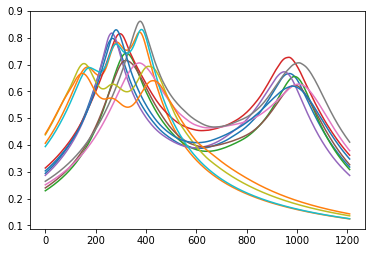

GO:0003674 acc 0.8148148148148148 random 0.8148148148148149 prec 0.0 recall 0.0


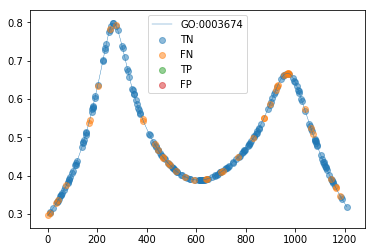

GO:0004984 acc 0.9835390946502057 random 0.8888888888888888 prec 0.9259259259259259 recall 0.9259259259259259


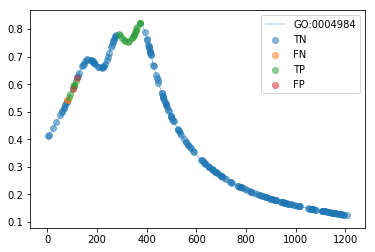

GO:0005515 acc 0.7654320987654321 random 0.7654320987654322 prec 0.0 recall 0.0


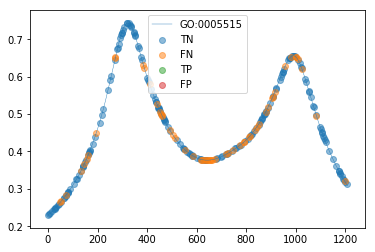

GO:0005575 acc 0.8842975206611571 random 0.8801652892561983 prec 1.0 recall 0.034482758620689655


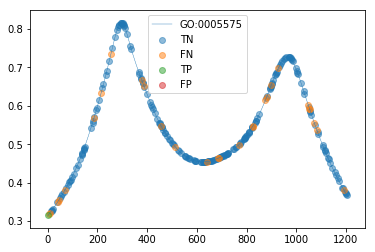

GO:0005634 acc 0.8024691358024691 random 0.8024691358024691 prec 0.0 recall 0.0


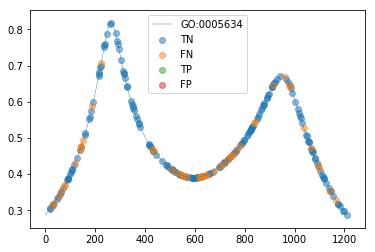

GO:0005737 acc 0.7942386831275721 random 0.7942386831275721 prec 0.0 recall 0.0


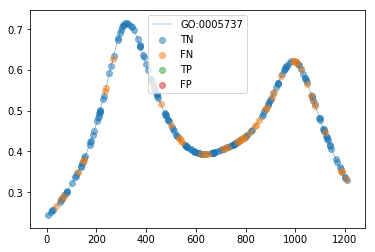

GO:0005829 acc 0.8641975308641975 random 0.8641975308641976 prec 0.0 recall 0.0


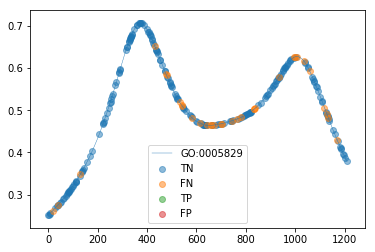

GO:0005886 acc 0.8806584362139918 random 0.8806584362139918 prec 0.0 recall 0.0


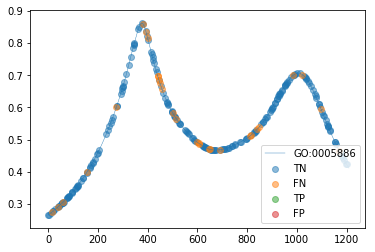

GO:0007186 acc 0.9876543209876543 random 0.8806584362139918 prec 0.9333333333333333 recall 0.9655172413793104


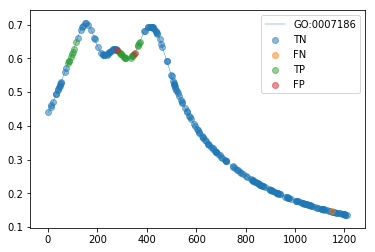

GO:0007608 acc 0.9876543209876543 random 0.8888888888888888 prec 0.9285714285714286 recall 0.9629629629629629


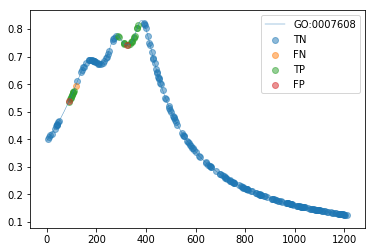

GO:0008150 acc 0.8518518518518519 random 0.8477366255144033 prec 1.0 recall 0.02702702702702703


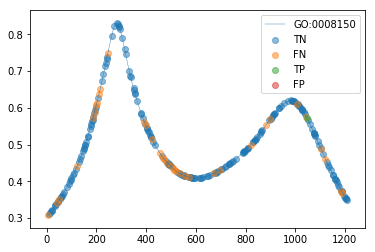

GO:0016021 acc 0.9753086419753086 random 0.8724279835390947 prec 0.9310344827586207 recall 0.8709677419354839


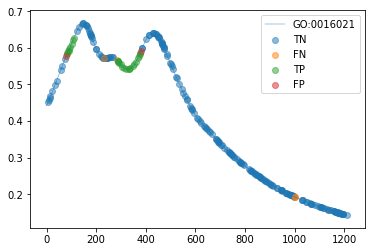

In [3]:
ORGANISMS = ['celegans', 'dmel', 'hg', 'mm', 'scer']
for organism in ORGANISMS:
    if organism != 'mm':
        continue
    for chromosome in os.listdir('../{}'.format(organism)):
        if chromosome != '9':
            continue
        directory = '../{}/{}'.format(organism, chromosome)
        seq_score = pd.read_csv('{}/seq_score.csv'.format(directory), sep='\t')
        if seq_score.shape[1] == 1:
            continue
        print(seq_score.shape[1], chromosome)
        true_train = {GO_id:pd.read_csv('{}/{}_train.csv'.format(directory, GO_id), sep='\t').pos.values for GO_id in seq_score.columns}
        true_test = {GO_id:pd.read_csv('{}/{}_test.csv'.format(directory, GO_id), sep='\t').pos.values for GO_id in seq_score.columns}
        for column in seq_score:
            plt.plot(seq_score[column].values)
        plt.show()

        false_train_size = 0.8

        for GO_id in seq_score.columns:
            false_pos = list(set(range(seq_score.shape[0])) - set(true_train[GO_id]) - set(true_test[GO_id]))
            false_train, false_test, _, _ = train_test_split(false_pos, false_pos, train_size=false_train_size)
            
            pos_train = np.concatenate((true_train[GO_id], false_train), axis=None)
            pos_test = np.concatenate((true_test[GO_id], false_test), axis=None)

            data_train = np.array(seq_score)[pos_train,:]
            data_test = np.array(seq_score)[pos_test,:]
            labels_train = np.concatenate((np.ones(len(true_train[GO_id])), np.zeros(len(false_train))), axis=None)
            labels_test = np.concatenate((np.ones(len(true_test[GO_id])), np.zeros(len(false_test))), axis=None)

            # Model
            clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 5))
            clf.fit(data_train, labels_train)
            pred = clf.predict(data_test)
            
            print(GO_id,
                  'acc', (pred == labels_test).mean(),
                  'random', 1 - labels_test.mean(),
                  'prec', precision_score(y_true=labels_test, y_pred=pred),
                  'recall', recall_score(y_true=labels_test, y_pred=pred))

            TP = np.intersect1d(np.where(labels_test == 1), np.where(pred == 1))
            FN = np.intersect1d(np.where(labels_test == 1), np.where(pred == 0))
            FP = np.intersect1d(np.where(labels_test == 0), np.where(pred == 1))
            TN = np.intersect1d(np.where(labels_test == 0), np.where(pred == 0))

            posTN = pos_test[TN]
            posTP = pos_test[TP]
            posFN = pos_test[FN]
            posFP = pos_test[FP]
            
            plt.plot(seq_score[GO_id], label=GO_id, linewidth=0.4)
            plt.scatter(posTN, seq_score[GO_id][posTN], label='TN', alpha=0.5)
            plt.scatter(posFN, seq_score[GO_id][posFN], label='FN', alpha=0.5)
            plt.scatter(posTP, seq_score[GO_id][posTP], label='TP', alpha=0.5)
            plt.scatter(posFP, seq_score[GO_id][posFP], label='FP', alpha=0.5)

            plt.legend()
            plt.show()

        print('=================================================================')
        print('=================================================================')
